# Morphological metrics for 3D volumetric ductal structures

This is a companion code of the paper:

*Homological features of airway tree on computed tomography and longitudinal change in lung function in patients with chronic obstructive pulmonary disease*

by Naoya Tanabe, Shizuo Kaji (equal contribution), Susumu Sato, Tomoki Maetani, Yusuke Shiraishi, Tsuyoshi Oguma, Ryo Sakamoto, Motonari Fukui, Shigeo Muro, Toyohiro Hirai

In [ ]:
# execute this cell for setting up the environment
# (it is required only for the first run)
!pip install -U git+https://github.com/shizuo-kaji/CubicalRipser_3dim
!pip install scikit-fmm pynrrd persim skan


## Function definition

In [1]:
from skimage.morphology import skeletonize,medial_axis,dilation
from skimage.draw import line_nd
from skimage.util import invert
import skimage
import matplotlib.pyplot as plt
import nrrd
import skfmm
import numpy as np
import cripser,tcripser
import pandas as pd
import os, zipfile, io, re, glob,pprint
import seaborn as sns
import persim
from scipy.stats import pearsonr, spearmanr, entropy
from scipy.ndimage import distance_transform_edt,binary_fill_holes
import queue
from genericpath import isfile
import skan
import networkx as nx
from tqdm.auto import tqdm
import joblib

# a variant of flood fill diffusing only to ascending neighbours
def ascending_flood(img,seed_point,tol=0, lo=-1000, high=1000):
    q = queue.Queue()
    q.put(tuple(seed_point)) # elements in the queue are tuples describing the coordinates of pixels to investigate
    neighbours = [(1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1)]
    tovisit = np.logical_and(img>=lo, img<high) # pixels within the valid value range: !! img<high excluding equality is important. Otherwise, outside may be included
    #print(tovisit.sum())
    mask = np.zeros(img.shape,dtype=bool)
    while not q.empty():
        p = q.get()
        #print(p,lo,high,tovisit.sum())
        tovisit[p]=False
        for v in neighbours:
            nextp = tuple(np.array(p)+np.array(v)) # check the neighbouring pixel
            if 0 <= nextp[0] < img.shape[0] and 0 <= nextp[1] < img.shape[1] and 0 <= nextp[2] < img.shape[2]:
                #print(p,nextp,tovisit[nextp],mask[nextp])
                if tovisit[nextp] and img[nextp] >= img[p]+tol and not mask[nextp]: # valid range and ascending and not yet marked 
                    #print(nextp,tovisit[nextp],tovisit.shape)
                    tovisit[nextp] = False
                    mask[nextp] = True
                    q.put(nextp) # add to the queue
    return(mask)

# find fattest node ID and its coorrdinates
def fattest_node(skeleton_img,mask,skel):
    inds = distance_transform_edt(np.ma.masked_array(~skeleton_img,~mask),return_distances=False,return_indices=True)
    inds = inds[:,mask]
    inv_dt = np.zeros(skeleton_img.shape)
    for x,y,z in tqdm(zip(inds[0],inds[1],inds[2]),total=inds[0].size):
        inv_dt[x,y,z]+=1
    degrees = np.diff(skel.graph.indptr)
    c=skel.coordinates[degrees>2].astype(int)
    fattest_node_id = np.argmax(inv_dt[c[:,0],c[:,1],c[:,2]])
    return(fattest_node_id,c[fattest_node_id])

# boxplot 
def vboxplot(HS,group_name=None,group=None,density=False,ylabel="#cycles",title="",ax=None):
    tdf = []
    X = np.array(HS)
    if len(X.shape)==1:
        X = X.reshape((-1,1))
    if density:
        X = X / X.sum(axis=1).reshape(-1,1)
    if group is None:
        group = np.zeros(len(X))
    if group_name is None:
        group_name=sorted(list(set(group)))
    for i,c in enumerate(group_name):
        criteria = (group==c)
        for u in X[criteria]:
            for l,v in enumerate(u):
                tdf.append({"bin":l, "group":c, "val":v}) 
    tdf=pd.DataFrame(tdf)
    cmap = plt.get_cmap("tab10")
    sns.set(style="whitegrid")
    if ax is None:
        fig, ax= plt.subplots(1,1,figsize=(15,8))
    sns.boxenplot(x="bin", y="val", hue="group", data=tdf, ax=ax)
    ax.set_ylabel(ylabel)
    #ax.legend(loc=1)
    ax.get_legend().remove()
    ax.set_title(title,y=-0.4,pad=-3)
    plt.tight_layout()

# count num of connected components
def count_cc(img, bg_color=-1):
    cc = {}
    for val in np.unique(img):
        if val != bg_color:
            labels = skimage.measure.label(img==val, background=0)
            cc[val] = labels.max()
    return(cc)

# parallel execution with progress bar
class ProgressParallel(joblib.Parallel):
    def __init__(self, total=None, *args, **kwargs):
        self._total = total
        super().__init__(*args, **kwargs)

    def __call__(self, *args, **kwargs):
        with tqdm(total=self._total) as self._pbar:
            return joblib.Parallel.__call__(self, *args, **kwargs)

    def print_progress(self):
        if self._total is None:
            self._pbar.total = self.n_dispatched_tasks
        self._pbar.n = self.n_completed_tasks
        self._pbar.refresh()

In [2]:
# compute 3d array whose values indicate generation numbers
def create_generation_volumes(volume,CTID,skeletonize_method=None, graph_creation="networkx", remove_trachea=True, verbose=False,save_intermediate=True):
    ## represent airway tree struture as a weighted graph
    binarised_volume = binary_fill_holes(volume>threshold) # binarised airway volume
    cc = skimage.measure.label(binarised_volume)
    if cc.max() != 1:
        print("The input volume must be connected! The result will be incorrect! Check the threshold.")
        area = [(cc==val).sum() for val in range(1,cc.max()+1)]
        print(f"Areas {area}...selecting the largest component")
        largest_cc_val = np.argsort(area)[-1]+1
        binarised_volume=(cc==largest_cc_val)
    skeleton = skeletonize(binarised_volume,method=skeletonize_method) # skelton(centerline)
    if verbose:
        print(f"binary image #connected components: volume {cc.max()}, skeleton {skimage.measure.label(skeleton).max()}")
    if save_intermediate:    
        nrrd.write(os.path.join(output_dir,f"{CTID}_skeleton.nrrd"), skeleton.astype(np.uint8), index_order='C')
        
    ## compute the graph structure of the skeleton
    skel = skan.csr.Skeleton(skeleton) #source_image=volume)
    if graph_creation=="skan":
        #NOTE: as of Skan 0.10, the detected skeleton can be disconnected even when the skelton image is connected.
        #This causes removal of airway branches since we consider the largest connected component
        degrees = np.diff(skel.graph.indptr) # list of degrees of the tree points
        node_ids = np.where(degrees!=2)[0][1:] # list of IDs of nodes in the tree; the ID=0 is a dummy so that we remove it
        branch = skan.csr.branch_statistics(skel.graph)
        path_coords = [skel.path_coordinates(i).astype(int) for i in range(skel.n_paths)]
        paths = np.vstack([skel.paths.indices[skel.paths.indptr[:-1]],skel.paths.indices[skel.paths.indptr[1:] - 1]]).T # paths[i] = [src[i],dst[i]]
        edges = paths # branch[:,:2].astype(int) # list of edges: [[Node ID, Node ID],...]
        skeleton_graph = nx.Graph()
        skeleton_graph.add_weighted_edges_from([e[0],e[1],w] for e,w in zip(edges,branch[:,2]))
        skeleton_MST = nx.minimum_spanning_tree(skeleton_graph)
    else:
        skeleton_graph = nx.from_scipy_sparse_array(skel.graph)
        degrees = np.array([skeleton_graph.degree[i] for i in range(len(skeleton_graph.nodes))])
        node_ids = np.where(degrees!=2)[0]
        # degree 2 nodes are contracted
        G = skeleton_graph.copy()
        for node in list(G.nodes()):
            if G.degree(node) == 2:
                edges = list(G.edges(node))
                G.add_edge(edges[0][1], edges[1][1])
                G.remove_node(node)
        paths = G.edges
        path_nodes = [nx.shortest_path(skeleton_graph,e[0],e[1]) for e in G.edges]       
        path_coords = [np.array([skel.coordinates[v] for v in p],dtype=int) for p in path_nodes]
        MST = nx.minimum_spanning_tree(skeleton_graph)
        skeleton_MST = G.subgraph(MST.nodes).copy() # this may still contain cycles
        skeleton_MST = nx.minimum_spanning_tree(skeleton_MST)
        #skeleton_MST.remove_edges_from(nx.selfloop_edges(skeleton_MST))
    skeleton_MST.remove_node(0) # 0 is always a dummy node
    if verbose:
        print(f'initial skeleton graph #nodes {(degrees !=2).sum()}, #path {skel.n_paths}, {len(paths)}, #voxels {skel.graph.shape[0]-1}, {(skeleton>0).sum()}, #nonzero {skel.graph.count_nonzero()}')
        print(f'minimum spanning tree #vertices {len(skeleton_MST.nodes())}, #edges {len(skeleton_MST.edges())}')

    ## remove cycles from the skeleton by taking the minimum spanning tree
    skeleton_cleaned = np.zeros_like(skeleton)
    for i,e in enumerate(paths):
        if skeleton_MST.has_edge(e[0],e[1]):
            #print(e[0],e[1])
            c=path_coords[i]
            skeleton_cleaned[c[:,0],c[:,1],c[:,2]]=255
        # else: ## edges removed
        #     print(e[0],e[1])
    skeleton_dt = distance_transform_edt(~skeleton_cleaned) # this will be compared to determine the voxels to be removed from the original volume

    ## identify trachea carina as the first deg>2 node with enough children
    c=skel.coordinates[degrees==1].astype(int) # leaf coordinates
    origin_id = np.where(degrees==1)[0][np.argmin(c[:,0])] # the leaf with minimum z-coordinates (should corresponds to throat)
    height = np.ptp(c[:,0])
    remove_nodes = [] # remove nodes in trachea
    if remove_trachea:
        bfs = nx.bfs_successors(skeleton_MST,source=origin_id)
        bfsT= nx.bfs_tree(skeleton_MST,source=origin_id)
        parent = {origin_id:origin_id}
        origin_id,succ = next(bfs)
        for k in succ:
            parent[k]=origin_id
        if verbose:
            print(f"Highest vert ID: {origin_id}, coord: {skel.coordinates[origin_id]}, height: {height}")
        while True: # identify the carina node
            if skeleton_MST.degree[origin_id] < 3: 
                #if skel.coordinates[parent[origin_id]][0] <= skel.coordinates[origin_id][0]:
                remove_nodes.append(origin_id)
                    #origin_id = dfs[origin_id][0]
            else:
                xyz = skel.coordinates[origin_id]
                num_children = np.array([len(nx.descendants(bfsT,s)) for s in succ])
                argn = np.argsort(num_children)
                s1,s2 = succ[argn[-1]], succ[argn[-2]]
                xyz1,xyz2 = skel.coordinates[s1], skel.coordinates[s2]
                # d1 = nx.descendants_at_distance(bfsT,succ[0],1) | nx.descendants_at_distance(bfsT,succ[0],2)
                # d2 = nx.descendants_at_distance(bfsT,succ[1],1) | nx.descendants_at_distance(bfsT,succ[1],2)
                # elif bool(d1 & d2): # this should not happen in MST
                #     if verbose:
                #         print("confluent branches:", d1,d2,origin_id,succ)
                #     remove_nodes.append(origin_id)
                if num_children[argn[-2]]<min_branches: # branches are too small
                    if verbose:
                        print(f"one of the branches of {origin_id} is too small having {num_children[argn[-2]]}, {num_children[argn[-1]]} children",succ)
                    remove_nodes.append(origin_id)
                elif abs(xyz1[2]-xyz2[2])<min_x_separation: # branches are too close
                    if verbose:
                        print(f"children of {origin_id} are too close in x-coords:",xyz1,xyz2,succ)
                    remove_nodes.append(origin_id)
                elif xyz[0]<height/5:
                    if verbose:
                        print(f"{origin_id} has too small z-coords:",xyz)
                    remove_nodes.append(origin_id)
                else:
                    break # carina found!
            # not found and continue
            origin_id,succ = next(bfs)
            for k in succ:
                parent[k]=origin_id
            if verbose:
                print(f"traversing node {origin_id} at {skel.coordinates[origin_id]} with childeren {succ}")
    if verbose:
        print("Trachea Carina: ",origin_id,skel.coordinates[origin_id]," trachea vertices: ",[(k,skel.coordinates[k]) for k in remove_nodes]) # skeleton_MST[k]
    ## construct the airway tree rooted at the trachea carina: remove vertices in trachea
    MST_nodes = set(skeleton_MST.nodes())
    skeleton_MST.remove_nodes_from(remove_nodes)
    #nx.write_gexf(skeleton_MST, "MST2.gexf")
    cc = max(nx.connected_components(skeleton_MST), key=len) # take the largest connected component
    if verbose:
        print("removed vertices: ",MST_nodes-set(cc)) # removed nodes
        # coord_nodes = skel.coordinates[degrees!=2]
        # for x in list(set(skeleton_MST.nodes())-set(cc)):
        #     dist = ((skel.coordinates[x]-coord_nodes)**2).sum(axis=1)
        #     print(x, np.sort(dist)[1] )
    #
    skeleton_MST = skeleton_MST.subgraph(cc).copy()
    if verbose:
        print(f'skeleton graph after trachea removal #vertices {len(skeleton_MST.nodes())}, #edges {len(skeleton_MST.edges())}')
    ## remove degree two nodes once again (except for the root) and leaf nodes with small generation
    node_removed = True
    removed_deg2, removed_leaf = 0,0
    while node_removed:
        node_removed = False
        gens = nx.shortest_path_length(skeleton_MST, source=origin_id, weight=None)
        for node in list(skeleton_MST.nodes()):
            if skeleton_MST.degree(node) == 1 and node != origin_id and gens[node]<4:
                skeleton_MST.remove_node(node)            
                node_removed = True
                removed_leaf += 1
                # if verbose:
                #     print(f"the leaf node {node} at generation {gens[node]} is removed.")
            elif skeleton_MST.degree(node) == 2 and node != origin_id:
                #print(f'node {node} removed!')
                edges = list(skeleton_MST.edges(node))
                skeleton_MST.add_edge(edges[0][1], edges[1][1])
                skeleton_MST.remove_node(node)
                node_removed = True
                removed_deg2 += 1
                # if verbose:
                #     print(f"the degree 2 node {node} at generation {gens[node]} is removed.")
    # count AC
    ac_gens = {}
    for i in range(1000):
        ac = list(gens.values()).count(i)
        if ac == 0:
            break
        ac_gens[i] = ac
    if verbose:
        print(f"#degree 2 nodes removed {removed_deg2}, #leaf nodes removed {removed_leaf}")
        print(f"#nodes at gens: {ac_gens}")
    paths = skeleton_MST.edges
    path_nodes = [nx.shortest_path(skeleton_graph,e[0],e[1]) for e in skeleton_MST.edges]       
    path_coords = [np.array([skel.coordinates[v] for v in p],dtype=int) for p in path_nodes]
    attr = {node: {'gen':gens[node], 'deg':skeleton_MST.degree(node)} for node in skeleton_MST}
    nx.set_node_attributes(skeleton_MST,attr)
    # if verbose:
    #     pos = nx.nx_agraph.graphviz_layout(skeleton_MST, prog="dot")
    #     nx.draw(skeleton_MST, pos,with_labels = True)
    #     nx.write_gexf(skeleton_MST,"test.gexf")

    origin = tuple(skel.coordinates[origin_id].astype(int)) # origin for geodesic distance for treeH
    if binarised_volume[origin]==0:
        print(f"The root is located at {origin}")
        print("The root must lie inside the ductal structure! Choose the right point.")

    ## assign airway generation to the skeleton tree
    skeleton_generation = np.zeros(skeleton.shape,dtype=np.uint16)
    for i,e in enumerate(paths):
        if skeleton_MST.has_edge(e[0],e[1]):
            #print(e[0],e[1])
            c=path_coords[i].astype(int)
            skeleton_generation[c[:,0],c[:,1],c[:,2]]=max(gens[e[0]],gens[e[1]])
        # else: ## edges removed
        #     print(e[0],e[1])
    print(f'maximum generation {skeleton_generation.max()}, #connected components {skimage.measure.label(skeleton_generation>0).max()}, #vertices {len(skeleton_MST.nodes())}, #edges {len(skeleton_MST.edges())}, #leaves {sum([i[1]==1 for i in skeleton_MST.degree])}')

    ## compute trachea removed volume: those voxels having different distance from the original and the final tree centerlines will be removed
    skeleton_MST_dt,inds = distance_transform_edt(skeleton_generation==0,return_indices=True)
    mask = (skeleton_dt != skeleton_MST_dt) ## regions to be removed
    trachea_removed = volume.copy()
    trachea_removed[mask] = volume.min()
    binarised_volume = binary_fill_holes(trachea_removed>threshold) # binarised airway volume

    ## airway generation volume
    volume_generation=skeleton_generation[inds[0],inds[1],inds[2]].reshape(volume.shape)
    volume_generation[~binarised_volume]=0
    if skimage.measure.label(skeleton_generation>0).max()>1:
        print("the volume is disconnected!")
    if save_intermediate:
        v = volume_generation.copy().astype(np.int8)
        v[(volume_generation>max_gen)]=0
        v[skeleton_generation>0] = 1 # -skeleton_generation[skeleton_generation>0] # distinguishable skeleton
        v[origin] = 1
        nrrd.write(os.path.join(output_dir,f"{CTID}_volume_gen1-{max_gen}.nrrd"), trachea_removed, index_order='C')
        #nrrd.write(os.path.join(output_dir,f"{CTID}_volume_generation.nrrd"), volume_generation, index_order='C')
        nrrd.write(os.path.join(output_dir,f"{CTID}_skeleton_cleaned.nrrd"), skeleton_cleaned.astype(np.uint8), index_order='C')
        nrrd.write(os.path.join(output_dir,f"{CTID}_generation.nrrd"), v, index_order='C')
        #nrrd.write(os.path.join(output_dir,f"{CTID}_skeleton_generation.nrrd"), skeleton_generation, index_order='C')

    return(skeleton_generation,volume_generation,trachea_removed,origin,ac_gens)


# compute the signed distance from the origin and the centerline
def geodesic_distance_transform(skeleton,binarised_volume,origin,restrict_to_centerline=True):
    roi = np.ones(skeleton.shape)
    roi[origin] = 0
    # negative of geodesic distance transform: 0 means the voxel on the ROI, 1 means outside.
    dist_vol = {"tree": (-skfmm.distance(np.ma.MaskedArray(roi,~binarised_volume))).filled(fill_value=OUTSIDE)}
    dist_vol["radial"] = (-skfmm.distance(np.ma.MaskedArray(~skeleton,~binarised_volume))).filled(fill_value=OUTSIDE)
    if restrict_to_centerline:
        dist_vol["tree"][~skeleton]=OUTSIDE # restrict to the centerline
    #dist_vol["tree"]=(-skfmm.distance(np.ma.MaskedArray(roi,~dilation(skeleton)))).filled(fill_value=OUTSIDE)
    return(dist_vol)

# cycle annotated volume
def annotated_volume(binarised_volume, skeleton, origin, metrics, H, mode, annot_type, annot_metric, verbosity=0):
    out = binarised_volume.copy().astype(np.uint8)
    vol = out.sum()
    dist_vol = geodesic_distance_transform(skeleton,binarised_volume,origin,restrict_to_centerline=False)
    if mode=="radial":
        tol = 0
    else:
        tol = 0.1

    # label classes
    char_cycles = []
    for i in range(num_bins[mode]):
        if annot_metric == "birth":
            char_cycles.append({'dim':0, 'b0':-metrics[f"{mode}_Birth_bin{i+1}"], 'b1':-metrics[f"{mode}_Birth_bin{i}"], 'l0':min_life[mode], 'l1':max_life[mode], 'col': i+2 })
        elif annot_metric == "life":
            char_cycles.append({'dim':0, 'l0':metrics[f"{mode}_Life_bin{i}"], 'l1':metrics[f"{mode}_Life_bin{i+1}"], 'b0':-np.inf, 'b1':np.inf, 'col': i+2 })
        elif annot_metric == "ratio":
            char_cycles.append({'dim':0, 'l0':metrics[f"{mode}_Ratio_bin{i}"], 'l1':metrics[f"{mode}_Ratio_bin{i+1}"], 'b0':None, 'b1':None, 'col': i+2 })
            
    # counter for each label
    cnt = np.zeros(len(char_cycles))

    # normalising by the maximum birth/life values
    for i,p in tqdm(enumerate(H[mode]), total=len(H[mode])):
        # iterate over PH cycles
        for j,cc in enumerate(char_cycles):
            d,b0,b1,l0,l1 = cc['dim'],cc['b0'],cc['b1'],cc['l0'],cc['l1']
            if p[0] != d:
                continue
            if annot_metric=="ratio" and not (l1>=abs((p[2]-p[1])/p[1])>=l0):
                continue                
            elif annot_metric!="ratio" and not ((l1>=p[2]-p[1]>=l0) and (b1>=p[1]>=b0)):
                continue
            # cycle to annotate
            bx,by,bz = p[3:6].astype(np.int32)
            dx,dy,dz = p[6:9].astype(np.int32)
            sp = (bx,by,bz)
            if verbosity > 1:
                print("birth (z,y,x)=",sp,"death (z,y,x)=",dx,dy,dz, "birth%, life%=",b0, l0)
            cnt[j] += 1
            if annot_type == 'fill':
                mask = ascending_flood(dist_vol[mode], seed_point=sp, lo=p[1], high=p[2], tol=tol)
                #mask[bx,by,bz] = True
                if verbosity > 0:
                    print(p[1],p[2],dist_vol[mode][sp], mask.sum())
                out[mask] = cc['col']
            elif annot_type == 'line':
                lin = line_nd((sp), (dx,dy,dz), endpoint=False)
                out[lin] = cc['col']
    print(f'cycle counts: ',cnt)
    print(f'label counts', [(i+2,(out==i+2).sum()/vol) for i in range(len(char_cycles))]+[('none',(out==1).sum()/vol)])
    return(out)


In [3]:
# PH computation for geodesic distances
def compute_PH(dist_vol,CTID,maxdim=2,save_intermediate=True):
    res = dict()
    H = dict()
    for k,mode in enumerate(modes):
        phfn = os.path.join(ph_output_dir[mode],f'{CTID}.npy')
        if os.path.isfile(phfn) and not recompute_PH:
            PH = np.load(phfn)
            print("precomputed PH loaded from ",phfn)
        else:
            if save_intermediate:
                nrrd.write(os.path.join(output_dir,f"{CTID}_{mode}_geodesic_dt.nrrd"), dist_vol[mode], index_order='C')
            PH = tcripser.computePH(dist_vol[mode], maxdim=maxdim) # use tcripser (instead of cripser) to account for diagonal connectivity
            np.save(phfn,PH)
            # import gudhi
            # gd = gudhi.CubicalComplex(top_dimensional_cells=dist_vol[mode])
            # p = np.array(gd.persistence(2,0)) # coeff = 2
            # print("Betti numbers: ", gd.persistent_betti_numbers(np.inf,-np.inf))

        if PH is not None:
            PH = PH[PH[:,2]<OUTSIDE] # remove cycles killed by outside region
            print(f'{mode}: betti0 {sum(PH[:,0]==0)}, betti1 {sum(PH[:,0]==1)}, betti2 {sum(PH[:,0]==2)}')
            PH = PH[PH[:,0]==0] # focus on PH0
            ## make histogram
            life = np.abs(PH[:,2] - PH[:,1])
            birth = np.abs(PH[:,1])
            if max_life[mode] is None:
                max_life[mode] = np.percentile(life,95)
            if max_birth[mode] is None:
                max_birth[mode] = np.percentile(birth,100)
            PH_entropy = entropy(life, base=2) # / np.log2(sum(life))
            life_hist, life_bin = np.histogram(life,bins=num_bins[mode], range=(min_life[mode],max_life[mode]))
            if density:
                life_hist = life_hist/life_hist.sum()
            birth_hist, birth_bin = np.histogram(birth,bins=num_bins[mode], range=(0,max_birth[mode]))
            if density:
                birth_hist = birth_hist/birth_hist.sum()
            ratio_hist, ratio_bin = np.histogram(life/np.abs(birth),bins=num_bins[mode], range=(0,1))
            if density:
                ratio_hist = ratio_hist/ratio_hist.sum()
            H[mode] = PH
            res[f"{mode}H_entropy"] = PH_entropy
            for i,x in enumerate(life_hist):
                res[f"{mode}H_Life_{i}"] = life_hist[i]
            for i,x in enumerate(life_bin):
                res[f"{mode}_Life_bin{i}"] = life_bin[i]        
            for i,x in enumerate(birth_hist):
                res[f"{mode}H_Birth_{i}"] = birth_hist[i]
            for i,x in enumerate(birth_bin):
                res[f"{mode}_Birth_bin{i}"] = birth_bin[i]        
            for i,x in enumerate(ratio_hist):
                res[f"{mode}H_Ratio_{i}"] = ratio_hist[i]
            for i,x in enumerate(ratio_bin):
                res[f"{mode}_Ratio_bin{i}"] = ratio_bin[i]        
    return(res,H)

# batch computation
def process_volume(volume_fn):
    CTID = os.path.splitext(os.path.basename(volume_fn))[0]
    print("\n",CTID)
    volume, header = nrrd.read(volume_fn, index_order='C') # EXAMPLE: we load a volume from an NRRD file; replace this line to load other types of volumes in 3d numpy array
    skeleton_generation,volume_generation,trachea_removed,origin,ac_gens = create_generation_volumes(volume,CTID,graph_creation="nx",remove_trachea=remove_trachea,verbose=verbose,save_intermediate=save_intermediate)
    res={'CTID':CTID,'trachea_z':origin[0],'trachea_y':origin[1],'trachea_x':origin[2]}
    if skip_compute_PH:
        H=None
    else:
        skeleton = (skeleton_generation>0)&(skeleton_generation<=max_gen)
        binarised_volume = (volume_generation>0)&(volume_generation<=max_gen)
        dist_vol = geodesic_distance_transform(skeleton,binarised_volume,origin,restrict_to_centerline=False)
        ress,H=compute_PH(dist_vol,CTID,save_intermediate=save_intermediate)
        res.update(ress)
    for k,v in ac_gens.items(): #count_cc(skeleton_generation).items():
        res[f'AC_gen{k}']=v
    return(res,H)



## Main starts here

In [6]:
# configulation

modes = ["tree","radial"] # PH computation modes

## maximum generation of branches used for analysis: 
# ## CAUTION: automatic generation assignment is not always perfect. Make sure by checking intermediate outputs in "output_dir"
max_gen = 5

## binarisation threshold
threshold = -2000

## input dir containing segmented airway CT in NRRD files
input_dir = 'NRRD'

input_files = glob.glob(os.path.join(input_dir,"*.nrrd"))
print(f'{len(input_files)} files will be processed.')
if len(input_files)<10:
    print(input_files)

## output dirs
output_dir = f"output_{max_gen}"
save_intermediate = False # if set to True, volume files of skeleton and generation are saved
verbose = True

## PH output dirs
ph_output_dir = {"tree": f"treeH_gen1-{max_gen}", "radial": f"radialH_gen1-{max_gen}"}

## parallel execution (beware of the memory usage)
num_parallel=3

## remove trachea?
# if set to False, the leaf node with the smallest z-coord will be regarded as the root
# if set to True, the graph is traversed from the leaf node with the smallest z-coord until a 'trachea carina like' node is found. Then, the traversed nodes are removed.
remove_trachea = True

## minimum difference in x-coordinates for the two children nodes of trachea carina
min_x_separation = 0 # the default value of 0 is usually fine
## minimum number of descendants for the two children nodes of trachea carina
min_branches = 20  # the default value of 20 is usually fine

## number of bins for PH metrics
num_bins = {"tree": 3, "radial": 3}
min_life = {"tree": 1, "radial": 1}
max_life = {"tree": None, "radial": 5}
max_birth =  {"tree": None, "radial": 10}

## the number of cycles are normalised to sum up to one, if set to True.
density = False

## magic number to indicate outside in distance transform (need not be modified)
OUTSIDE=1

## DEBUG options
recompute_PH = True # if set to False, load PH from file
skip_compute_PH = False # if set to True, perform only generation computation without PH.
#debugdf = pd.read_csv("20220507.csv",index_col="CTID")
debugdf=None

## create output dirs
[os.makedirs(dn,exist_ok=True) for dn in ph_output_dir.values()]
os.makedirs(output_dir,exist_ok=True)


217 files will be processed.


In [ ]:
# create data frame containing results
results,PHs = [],{}
error_id = []
if num_parallel==1:
    for volume_fn in tqdm(input_files):
        res,H=process_volume(volume_fn)
        results.append(res)
        PHs[res['CTID']] = H
        if debugdf is not None:
            if res['CTID'] in debugdf.index:
                true_z = debugdf.loc[res['CTID'],'trachea_z']
                print(f"estimate: {res['trachea_z']}, truth: {true_z}")
                if abs(true_z-res['trachea_z'])>2:
                    print(f"\n\nLARGE DIFF!:\n\n")
                    error_id.append((res['CTID'],res['trachea_z'],true_z))
            else:
                print(f"{res['CTID']} is not in the database")
else:
    for res,H in ProgressParallel(n_jobs=num_parallel, total=len(input_files))(joblib.delayed(process_volume)(f) for f in input_files):
        results.append(res)
        PHs[res['CTID']] = H

results = pd.DataFrame(results)
res = results.set_index('CTID')
res.to_csv(os.path.join(output_dir,f"results2022_{max_gen}.csv"))

In [ ]:
# results table
res


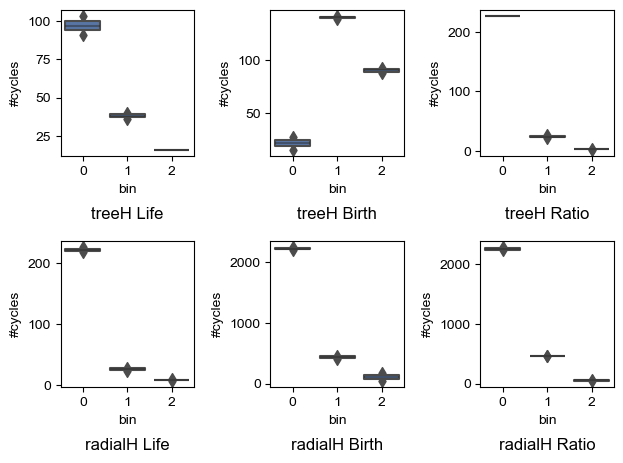

In [21]:
# boxplot
fix,ax = plt.subplots(len(modes),3)
for i,mode in enumerate(modes):
    for j,t in enumerate(['Life','Birth','Ratio']):
        X = results[[f'{mode}H_{t}_0',f'{mode}H_{t}_1',f'{mode}H_{t}_2']].values
        vboxplot(X,ax=ax[i,j],title=f'{mode}H {t}')


## Result presentation
Comutation of metrics must be executed first.

In [ ]:
## select which subject to look at
k = 0
metrics = results.iloc[k]
CTID = metrics['CTID']
H = PHs[CTID]
print(metrics)


In [ ]:
## plot persistence diagram
fig, ax= plt.subplots(1,2,figsize=(15,8))
persim.plot_diagrams(np.abs(H["tree"][:,1:3]),legend=False, lifetime=False, ax=ax[0],title="treeH0")
persim.plot_diagrams(np.abs(H["radial"][:,1:3]),xy_range=(0,max_life["radial"],0,max_life["radial"]), legend=False, lifetime=False, ax=ax[1],title="radialH0")


### Create a volume containing labels for PH cycles

use ITK-snap for visualisation: load the original CT as the main volume and the output of this as segmentation

http://www.itksnap.org/pmwiki/pmwiki.php


In [24]:
## annotation type
annot_type = 'fill' # fill, line
annot_metric = "life" # life, birth, ratio

# print information
verbosity = 0


In [25]:
# output filename
outfn = os.path.join(output_dir,f'{CTID}_{mode}_{annot_metric}_{annot_type}_gen1-{max_gen}.nrrd')

# load the original volume
volume, header = nrrd.read(input_files[k], index_order='C')
skeleton_generation,volume_generation,trachea_removed,origin,ac_gens = create_generation_volumes(volume,CTID,graph_creation="nx",remove_trachea=remove_trachea,verbose=verbosity,save_intermediate=False)
skeleton = (skeleton_generation>0)&(skeleton_generation<=max_gen)
binarised_volume = (volume_generation>0)&(volume_generation<=max_gen)
for mode in modes:
    annotated = annotated_volume(binarised_volume, skeleton, origin, metrics, H, mode, annot_type, annot_metric, verbosity)
    nrrd.write(outfn, annotated, index_order='C')
    print(f'successfully created {outfn}')

The root is located at  (111, 185, 174)
maximum generation 18, #connected components 1, #vertices 347, #edges 346, #leaves 163


  0%|          | 0/255 [00:00<?, ?it/s]

cycle counts:  [91. 36. 16.]
label counts [(2, 0.049459236354987196), (3, 0.08099562072390973), (4, 0.08253466343934072), ('none', 0.7870104794817624)]
successfully created output/Test01_radial_life_fill_gen1-30.nrrd


  0%|          | 0/2798 [00:00<?, ?it/s]

cycle counts:  [225.  29.  10.]
label counts [(2, 0.023043666839226002), (3, 0.008758552180543703), (4, 0.0034558504610132496), ('none', 0.9647419305192171)]
successfully created output/Test01_radial_life_fill_gen1-30.nrrd
